## Midterm: HR Data Preprocessing and Feature Engineering

This notebook prepares the Kaggle HR dataset, aug_train.csv, for supervised learning and predicts the target, which indicates whether a candidate is seeking a job change. We load the data without skipping lines, evaluate data quality, create a leakage-safe preprocessing pipeline, and assess baseline models while displaying before and after views of key steps.

Major Areas:
- Data quality check and text standardization.
- Ordinal conversions for experience, last new job, company size, and education level.
- Imputation of missing values in a train-only pipeline.
- Feature engineering for training intensity, job stability, and city by experience interaction.
- Scaling and log normalization for numeric features.
- One-hot encoding for nominal categories and city frequency encoding.
- Splitting data into train and test sets, fitting the pipeline on training data only, and previewing processed features.
- Baseline evaluation with logistic regression and a class-weighted variant, along with a concise run summary.


## Section 0. Title and setup
We set up the environment for the HR dataset preprocessing and feature engineering workflow. We install core libraries, import dependencies, fix the random seed, configure plotting, and print library versions to make runs reproducible.  

In [1]:
import sys
!{sys.executable} -m pip install --quiet pandas numpy matplotlib seaborn scikit-learn

import io
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    RocCurveDisplay,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

warnings.filterwarnings("ignore", category=FutureWarning)

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"matplotlib version: {plt.matplotlib.__version__}")
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

pandas version: 2.3.1
numpy version: 1.26.4
seaborn version: 0.13.2
matplotlib version: 3.10.5
scikit-learn version: 1.7.1


## Section 1. Load data without skipping lines
We load aug_train.csv without skipping any lines and verify row counts. We display a preview, schema, target distribution, and check that enrollee_id is unique.

In [2]:
data_path = Path("aug_train.csv")

if not data_path.exists():
    raise FileNotFoundError("Expected aug_train.csv in the working directory.")

with data_path.open("r", encoding="utf-8") as f:
    raw_line_count = sum(1 for _ in f)

df = pd.read_csv(data_path)
expected_rows = raw_line_count - 1
assert len(df) == expected_rows, f"Expected {expected_rows} rows but loaded {len(df)}."

print(f"Loaded {len(df)} rows from {data_path.name} without skipping any lines.")
print(f"Shape: {df.shape}")

display(df.head())
info_buffer = io.StringIO()
df.info(buf=info_buffer)
print(info_buffer.getvalue())

if "target" not in df.columns:
    raise KeyError("The target column is missing from the dataset.")

print("Target distribution:")
print(df["target"].value_counts(dropna=False).to_string())

duplicate_ids = df["enrollee_id"].duplicated().sum()
if duplicate_ids == 0:
    print("enrollee_id is unique.")
else:
    print(f"enrollee_id has {duplicate_ids} duplicates.")

initial_row_count = len(df)
target_col = "target"
id_col = "enrollee_id"
df_original = df.copy()

Loaded 19158 rows from aug_train.csv without skipping any lines.
Shape: (19158, 14)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

## Section 2. Data quality assessment
We perform an initial data quality assessment. We summarize missing values, duplicates, data types, and cardinalities, and visualize missingness and two key numeric distributions.

Duplicate rows: 0
Duplicate enrollee_id values: 0


,missing_count,missing_percent
company_type,6140,32.049274
company_size,5938,30.994885
gender,4508,23.530640
major_discipline,2813,14.683161
education_level,460,2.401086
last_new_job,423,2.207955
enrolled_university,386,2.014824
experience,65,0.339284
enrollee_id,0,0.000000
city,0,0.000000


,unique_values
city,123
experience,22
company_size,8
major_discipline,6
company_type,6
last_new_job,6
education_level,5
gender,3
enrolled_university,3
relevent_experience,2


,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


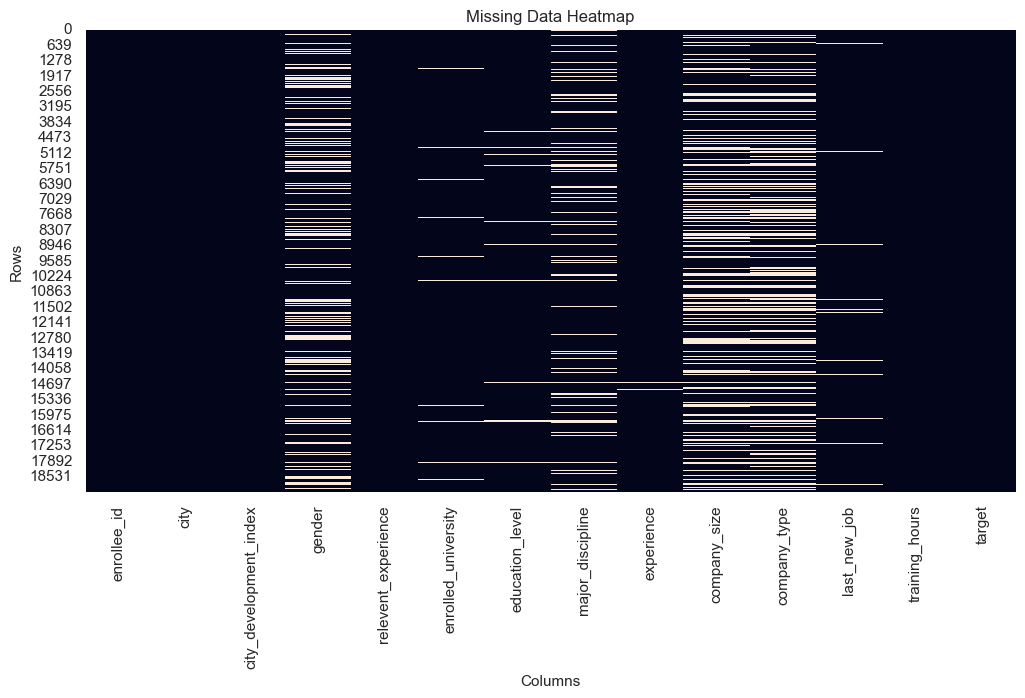

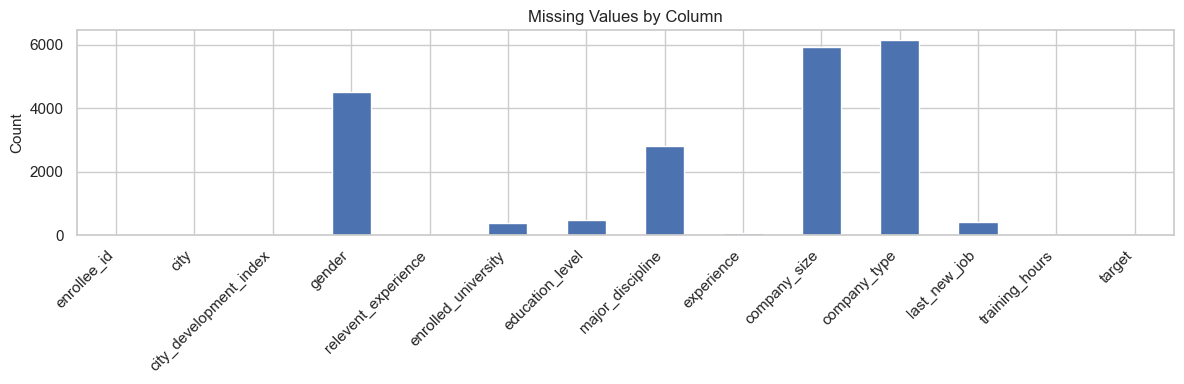

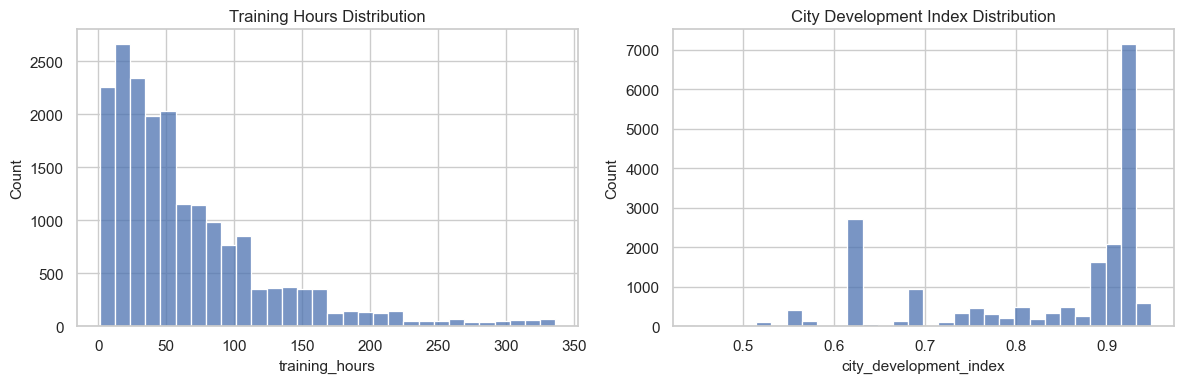

In [3]:
missing_counts = df.isna().sum()
missing_percent = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent,
}).sort_values("missing_count", ascending=False)

duplicate_rows = df.duplicated().sum()
duplicate_enrollee_id = df[id_col].duplicated().sum()

numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()

categorical_cardinality = pd.DataFrame({
    "unique_values": df[categorical_columns].nunique(dropna=True)
}).sort_values("unique_values", ascending=False)

numeric_describe = df[numeric_columns].describe()

print(f"Duplicate rows: {duplicate_rows}")
print(f"Duplicate enrollee_id values: {duplicate_enrollee_id}")

display(missing_summary)
display(categorical_cardinality)
display(numeric_describe)

plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

plt.figure(figsize=(12, 4))
missing_counts.plot(kind="bar")
plt.title("Missing Values by Column")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df["training_hours"], bins=30, ax=axes[0], kde=False)
axes[0].set_title("Training Hours Distribution")
axes[0].set_xlabel("training_hours")

sns.histplot(df["city_development_index"], bins=30, ax=axes[1], kde=False)
axes[1].set_title("City Development Index Distribution")
axes[1].set_xlabel("city_development_index")

plt.tight_layout()
plt.show()

## Section 3. Target and feature definition
We define the supervised target and the initial feature set. We keep the identifier separate and do not use it as a feature.

In [4]:
feature_cols = [
    "city",
    "city_development_index",
    "gender",
    "relevent_experience",
    "enrolled_university",
    "education_level",
    "major_discipline",
    "experience",
    "company_size",
    "company_type",
    "last_new_job",
    "training_hours",
]

base_feature_count = len(feature_cols)
print(f"Features selected ({base_feature_count} columns):")
print(feature_cols)

Features selected (12 columns):
['city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours']


## Section 4. Clean raw categorical text and fix inconsistencies
We standardize categorical text, align common variants, and show before‑and‑after samples with value‑count comparisons.

In [5]:
text_columns = df[feature_cols].select_dtypes(include="object").columns.tolist()
text_preview_before = df[text_columns].head(5).copy()
text_before = df[text_columns].copy()

def standardize_text(series):
    return series.str.strip().str.lower()

df[text_columns] = df[text_columns].apply(lambda col: standardize_text(col) if col.dtype == object else col)

company_size_replacements = {
    "oct-49": "10/49",
    "10-49": "10/49",
    "10 / 49": "10/49",
    "10 to 49": "10/49",
    "10\49": "10/49",
}
df["company_size"] = df["company_size"].replace(company_size_replacements)

enrolled_map = {
    "no enrollment": "no_enrollment",
    "no_enrollment": "no_enrollment",
    "full time course": "full_time_course",
    "full_time_course": "full_time_course",
    "part time course": "part_time_course",
    "part_time_course": "part_time_course",
}
df["enrolled_university"] = df["enrolled_university"].replace(enrolled_map)

gender_map = {
    "m": "male",
    "male": "male",
    "f": "female",
    "female": "female",
}
df["gender"] = df["gender"].replace(gender_map)
df.loc[df["gender"].notna() & ~df["gender"].isin(["male", "female", "other"]), "gender"] = "other"

text_after = df[text_columns].copy()
text_corrections = int(((text_before != text_after) & ~(text_before.isna() & text_after.isna())).sum().sum())
print(f"Text normalisation adjustments applied to {text_corrections} values.")

comparison_preview = pd.concat([text_preview_before, df[text_columns].head(5)], axis=1, keys=["before", "after"])
display(comparison_preview)

for col in ["company_size", "enrolled_university", "gender"]:
    before_counts = text_before[col].value_counts(dropna=False)
    after_counts = text_after[col].value_counts(dropna=False)
    counts_df = pd.concat([before_counts, after_counts], axis=1, keys=["before", "after"]).fillna(0).astype(int)
    print(f"Value counts before vs after for {col}:")
    display(counts_df)

Text normalisation adjustments applied to 86824 values.


before                                                      \
       city gender      relevent_experience enrolled_university   
0  city_103   Male  Has relevent experience       no_enrollment   
1   city_40   Male   No relevent experience       no_enrollment   
2   city_21    NaN   No relevent experience    Full time course   
3  city_115    NaN   No relevent experience                 NaN   
4  city_162   Male  Has relevent experience       no_enrollment   

                                                                            \
  education_level major_discipline experience company_size    company_type   
0        Graduate             STEM        >20          NaN             NaN   
1        Graduate             STEM         15        50-99         Pvt Ltd   
2        Graduate             STEM          5          NaN             NaN   
3        Graduate  Business Degree         <1          NaN         Pvt Ltd   
4         Masters             STEM        >20        50-99  Funded Startup   

                   after                                                      \
  last_new_job      city gender      relevent_experience enrolled_university   
0            1  city_103   male  has relevent experience       no_enrollment   
1           >4   city_40   male   no relevent experience       no_enrollment   
2        never   city_21    NaN   no relevent experience    full_time_course   
3        never  city_115    NaN   no relevent experience                 NaN   
4            4  city_162   male  has relevent experience       no_enrollment   

                                                                            \
  education_level major_discipline experience company_size    company_type   
0        graduate             stem        >20          NaN             NaN   
1        graduate             stem         15        50-99         pvt ltd   
2        graduate             stem          5          NaN             NaN   
3        graduate  business degree         <1          NaN         pvt ltd   
4         masters             stem        >20        50-99  funded startup   

                
  last_new_job  
0            1  
1           >4  
2        never  
3        never  
4            4

Value counts before vs after for company_size:


,before,after
company_size,,
NaN,5938,5938
50-99,3083,3083
100-500,2571,2571
10000+,2019,2019
10/49,1471,1471
1000-4999,1328,1328
<10,1308,1308
500-999,877,877
5000-9999,563,563


Value counts before vs after for enrolled_university:


,before,after
enrolled_university,,
no_enrollment,13817,13817
Full time course,3757,0
Part time course,1198,0
NaN,386,386
full_time_course,0,3757
part_time_course,0,1198


Value counts before vs after for gender:


,before,after
gender,,
Male,13221,0
NaN,4508,4508
Female,1238,0
Other,191,0
male,0,13221
female,0,1238
other,0,191


## Section 5. Type conversions for ordinal-like fields
We convert ordered categories to numbers for modeling. We add derived fields for experience, time since last job change, company size, and education level, and preview the mappings.

In [6]:
experience_map = {
    "<1": 0.5,
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9,
    "10": 10,
    "11": 11,
    "12": 12,
    "13": 13,
    "14": 14,
    "15": 15,
    "16": 16,
    "17": 17,
    "18": 18,
    "19": 19,
    "20": 20,
    ">20": 21,
}
df["experience_years"] = df["experience"].map(experience_map)

last_new_job_map = {
    "never": 0,
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    ">4": 5,
}
df["last_new_job_years"] = df["last_new_job"].map(last_new_job_map)

company_size_order = ["<10", "10/49", "50-99", "100-500", "500-999", "1000-4999", "5000-9999", "10000+"]
company_size_mid = {
    "<10": 5,
    "10/49": 30,
    "50-99": 75,
    "100-500": 300,
    "500-999": 750,
    "1000-4999": 3000,
    "5000-9999": 7500,
    "10000+": 10000,
}
df["company_size_ordered"] = pd.Categorical(df["company_size"], categories=company_size_order, ordered=True)
df["company_size_num"] = df["company_size"].map(company_size_mid)

education_map = {
    "primary school": 0,
    "high school": 1,
    "graduate": 2,
    "masters": 3,
    "phd": 4,
}
df["education_level_ordinal"] = df["education_level"].map(education_map)

derived_features = [
    "experience_years",
    "last_new_job_years",
    "company_size_num",
    "education_level_ordinal",
]
for col in derived_features:
    if col not in feature_cols:
        feature_cols.append(col)

conversion_preview = df[[
    "experience", "experience_years",
    "last_new_job", "last_new_job_years",
    "company_size", "company_size_num",
    "education_level", "education_level_ordinal",
]].head(10)
display(conversion_preview)

,experience,experience_years,last_new_job,last_new_job_years,company_size,company_size_num,education_level,education_level_ordinal
0,>20,21.0,1,1.0,NaN,NaN,graduate,2.0
1,15,15.0,>4,5.0,50-99,75.0,graduate,2.0
2,5,5.0,never,0.0,NaN,NaN,graduate,2.0
3,<1,0.5,never,0.0,NaN,NaN,graduate,2.0
4,>20,21.0,4,4.0,50-99,75.0,masters,3.0
5,11,11.0,1,1.0,NaN,NaN,graduate,2.0
6,5,5.0,1,1.0,50-99,75.0,high school,1.0
7,13,13.0,>4,5.0,<10,5.0,graduate,2.0
8,7,7.0,1,1.0,50-99,75.0,graduate,2.0
9,17,17.0,>4,5.0,10000+,10000.0,graduate,2.0


## Section 6. Missing value analysis and imputation plan
We quantify missing values for the modeling columns and illustrate median and mode imputation on a demo copy only. The original dataframe keeps its NaNs so the real imputation occurs inside the train‑only pipeline and remains leakage‑safe. We record counts for the summary.

In [7]:
numeric_impute_cols = [
    "city_development_index",
    "training_hours",
    "experience_years",
    "last_new_job_years",
    "company_size_num",
    "education_level_ordinal",
]

categorical_impute_cols = [
    "city",
    "gender",
    "relevent_experience",
    "enrolled_university",
    "major_discipline",
    "company_type",
]

imputation_targets = numeric_impute_cols + categorical_impute_cols

# Count missing values BEFORE (on the real df)
missing_before = df[imputation_targets].isna().sum()

# Demo-only copy for illustrations so we do not leak test information
df_imputation_demo = df.copy(deep=True)

# Numeric: median on the demo copy
numeric_impute_values = {}
for col in numeric_impute_cols:
    med = df_imputation_demo[col].median()
    numeric_impute_values[col] = med
    df_imputation_demo[col] = df_imputation_demo[col].fillna(med)

# Categorical: mode on the demo copy
categorical_impute_values = {}
for col in categorical_impute_cols:
    mode_series = df_imputation_demo[col].mode(dropna=True)
    mode_val = mode_series.iloc[0] if not mode_series.empty else "missing"
    categorical_impute_values[col] = mode_val
    df_imputation_demo[col] = df_imputation_demo[col].fillna(mode_val)

# Count missing values AFTER (still on the demo copy)
missing_after = df_imputation_demo[imputation_targets].isna().sum()

# Totals for Section 13 summary
missing_before_total = int(missing_before.sum())
missing_after_total = int(missing_after.sum())

print("Missing values BEFORE imputation (real df):")
display(missing_before.to_frame(name="missing_count_before"))

print("Missing values AFTER imputation (demo copy):")
display(missing_after.to_frame(name="missing_count_after"))

assert missing_after_total == 0, "Imputation demo failed to resolve all missing values."
print("All missing values filled in the imputation demo copy. The original df retains NaNs for pipeline-based imputation.")

Missing values BEFORE imputation (real df):


,missing_count_before
city_development_index,0
training_hours,0
experience_years,65
last_new_job_years,423
company_size_num,5938
education_level_ordinal,460
city,0
gender,4508
relevent_experience,0
enrolled_university,386


Missing values AFTER imputation (demo copy):


,missing_count_after
city_development_index,0
training_hours,0
experience_years,0
last_new_job_years,0
company_size_num,0
education_level_ordinal,0
city,0
gender,0
relevent_experience,0
enrolled_university,0


All missing values filled in the imputation demo copy. The original df retains NaNs for pipeline-based imputation.


## Section 7. One hot and ordinal encoding setup
We define the columns for numeric and categorical processing and register custom transformers used later in the pipeline.

In [8]:
numeric_features = [
    "city_development_index",
    "training_hours",
    "experience_years",
    "last_new_job_years",
    "company_size_num",
    "education_level_ordinal",
]

categorical_features = [
    "city",
    "gender",
    "relevent_experience",
    "enrolled_university",
    "major_discipline",
    "company_type",
]

model_input_features = numeric_features + categorical_features

print("Numeric features:")
print(numeric_features)
print("Categorical features:")
print(categorical_features)

# Custom transformers for leakage-safe preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns, factor=1.5):
        self.columns = columns
        self.factor = factor

    def fit(self, X, y=None):
        self.bounds_ = {}
        X_ = pd.DataFrame(X, columns=self.columns) if not isinstance(X, pd.DataFrame) else X
        for col in self.columns:
            q1 = X_[col].quantile(0.25)
            q3 = X_[col].quantile(0.75)
            iqr = q3 - q1
            self.bounds_[col] = (q1 - self.factor * iqr, q3 + self.factor * iqr)
        return self

    def transform(self, X):
        check_is_fitted(self, "bounds_")
        X_ = X.copy()
        for col, (lo, hi) in self.bounds_.items():
            X_[col] = X_[col].clip(lo, hi)
        return X_

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.asarray(self.columns)
        return np.asarray(input_features)

class CityFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        X_ = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=[self.column])
        self.freq_ = X_[self.column].value_counts()
        return self

    def transform(self, X):
        check_is_fitted(self, "freq_")
        X_ = X.copy()
        X_["city_frequency"] = X_[self.column].map(self.freq_).fillna(0).astype(float)
        return X_[["city_frequency"]]

    def get_feature_names_out(self, input_features=None):
        return np.asarray(["city_frequency"])

class Log1pTransformer(FunctionTransformer):
    def __init__(self, columns):
        self.columns = columns
        super().__init__(self._log1p, validate=False)

    def _log1p(self, X):
        X = X.copy()
        X[self.columns] = np.log1p(X[self.columns])
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.asarray(self.columns)
        return np.asarray(input_features)

Numeric features:
['city_development_index', 'training_hours', 'experience_years', 'last_new_job_years', 'company_size_num', 'education_level_ordinal']
Categorical features:
['city', 'gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']


## Section 8. Scaling and normalization comparison
We compare raw distributions with standard and min‑max scaling for two numeric features to motivate our choice. The final pipeline uses standard scaling.

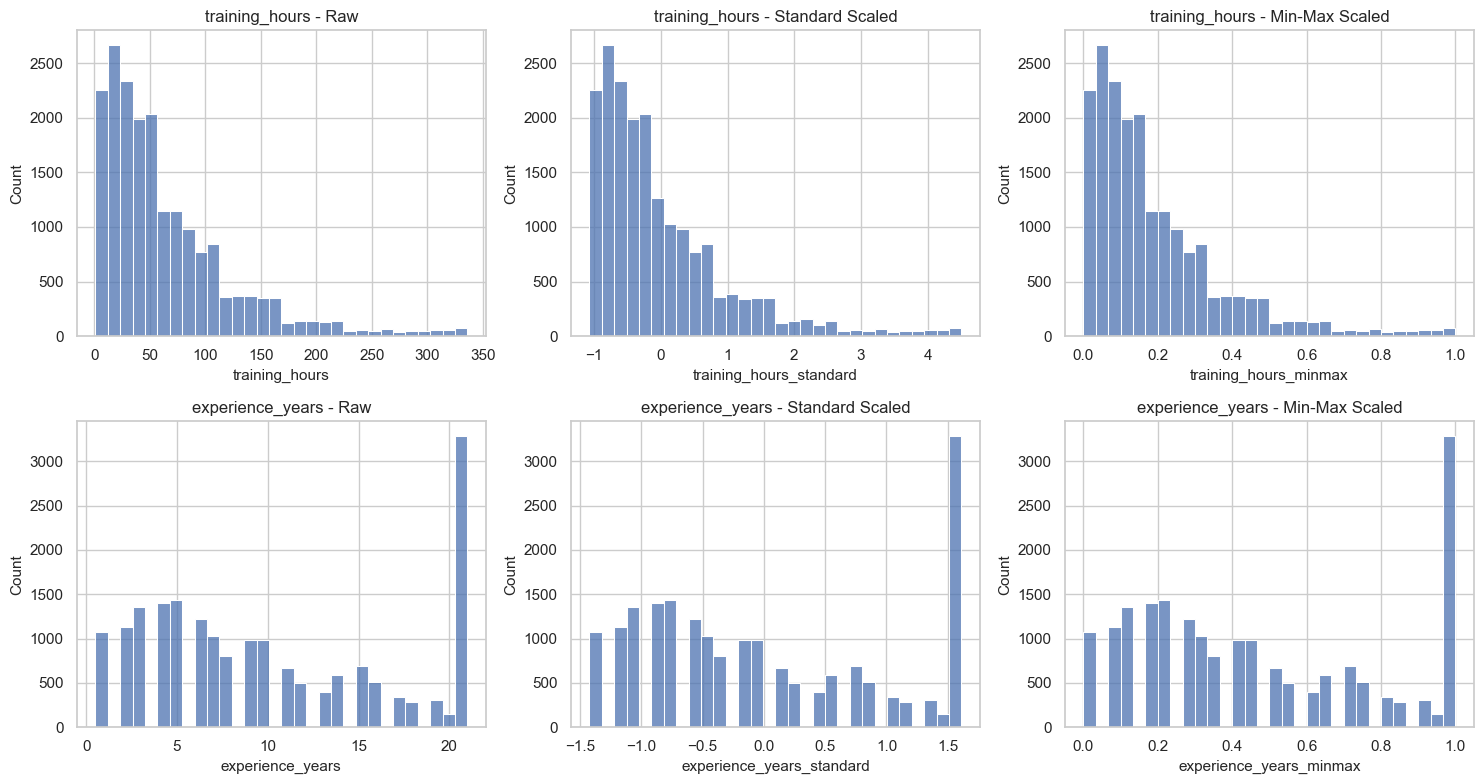

In [9]:
scale_features = ["training_hours", "experience_years"]
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# Fit scalers on df for visualization; the live pipeline handles imputation on X_train
standard_scaled = pd.DataFrame(
    scaler_standard.fit_transform(df[scale_features]),
    columns=[f"{col}_standard" for col in scale_features],
)

minmax_scaled = pd.DataFrame(
    scaler_minmax.fit_transform(df[scale_features]),
    columns=[f"{col}_minmax" for col in scale_features],
)

# Plot raw vs. scaled side-by-side
fig, axes = plt.subplots(len(scale_features), 3, figsize=(15, 8))

for idx, feature in enumerate(scale_features):
    # Raw
    sns.histplot(df[feature], bins=30, ax=axes[idx, 0], kde=False)
    axes[idx, 0].set_title(f"{feature} - Raw")
    axes[idx, 0].set_xlabel(feature)

    # Standard scaled
    sns.histplot(standard_scaled[f"{feature}_standard"], bins=30, ax=axes[idx, 1], kde=False)
    axes[idx, 1].set_title(f"{feature} - Standard Scaled")
    axes[idx, 1].set_xlabel(f"{feature}_standard")

    # Min-max scaled
    sns.histplot(minmax_scaled[f"{feature}_minmax"], bins=30, ax=axes[idx, 2], kde=False)
    axes[idx, 2].set_title(f"{feature} - Min-Max Scaled")
    axes[idx, 2].set_xlabel(f"{feature}_minmax")

plt.tight_layout()
plt.show()

## Section 9. Outlier detection and capping
We estimate outlier bounds with IQR and illustrate capping on a demo copy for visualization. The dataset used for modeling is not modified here. Robust capping is applied inside the train‑only pipeline.

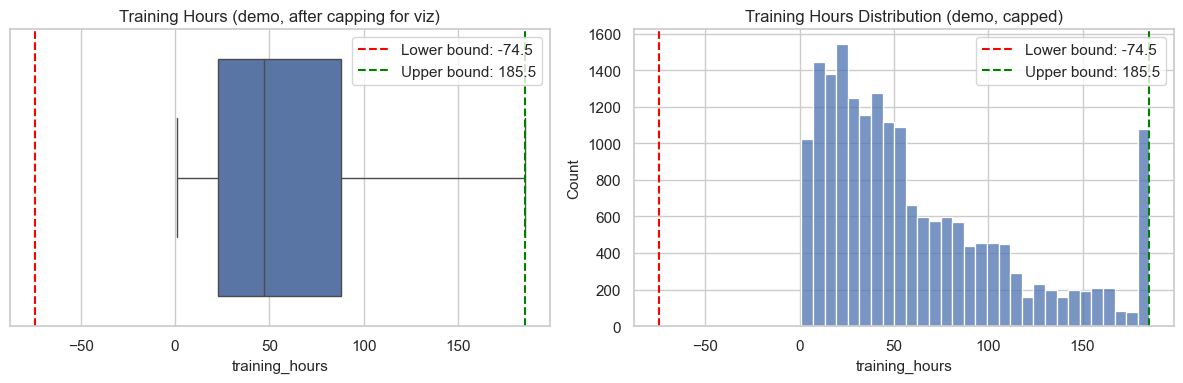

Outlier (demo) summary for visualization:


,lower_bound,upper_bound,capped_below_demo,capped_above_demo
training_hours,-74.5,185.5,0.0,984.0
experience_years,-14.0,34.0,0.0,0.0


Note: The dataset itself is NOT modified here. Robust capping is implemented inside the pipeline.


In [10]:
def calculate_iqr_bounds(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    return lower_bound, upper_bound

features_to_cap = ["training_hours", "experience_years"]
outlier_summary = {}
df_outlier_demo = df[features_to_cap].copy()

for feature in features_to_cap:
    lower, upper = calculate_iqr_bounds(df_outlier_demo[feature])
    below = int((df_outlier_demo[feature] < lower).sum())
    above = int((df_outlier_demo[feature] > upper).sum())
    outlier_summary[feature] = {
        "lower_bound": lower, "upper_bound": upper,
        "capped_below_demo": below, "capped_above_demo": above,
    }
    # demo capping for visualization only
    df_outlier_demo[feature] = df_outlier_demo[feature].clip(lower=lower, upper=upper)

training_lower = outlier_summary["training_hours"]["lower_bound"]
training_upper = outlier_summary["training_hours"]["upper_bound"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df_outlier_demo["training_hours"], ax=axes[0])
axes[0].set_title("Training Hours (demo, after capping for viz)")
axes[0].axvline(training_lower, color="red", linestyle="--", label=f"Lower bound: {training_lower:.1f}")
axes[0].axvline(training_upper, color="green", linestyle="--", label=f"Upper bound: {training_upper:.1f}")
axes[0].legend()

sns.histplot(df_outlier_demo["training_hours"], bins=30, ax=axes[1], kde=False)
axes[1].axvline(training_lower, color="red", linestyle="--", label=f"Lower bound: {training_lower:.1f}")
axes[1].axvline(training_upper, color="green", linestyle="--", label=f"Upper bound: {training_upper:.1f}")
axes[1].set_title("Training Hours Distribution (demo, capped)")
axes[1].set_xlabel("training_hours")
axes[1].legend()

plt.tight_layout()
plt.show()

outlier_summary_df = pd.DataFrame(outlier_summary).T
print("Outlier (demo) summary for visualization:")
display(outlier_summary_df)
print("Note: The dataset itself is NOT modified here. Robust capping is implemented inside the pipeline.")

## Section 10. Feature engineering
We add three domain features inside the train-fit pipeline to avoid leakage. The features are training_intensity, job_stability, and city_exp_interaction. They are created from existing columns with simple, interpretable formulas. We preview a few rows to confirm the shapes, and Section 11 consumes these features in the ColumnTransformer.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DomainFeatureEngineer(BaseEstimator, TransformerMixin):
    """Create HR-specific features safely inside the pipeline.

    Features:
      training_intensity  = training_hours / (experience_years + 1)
      job_stability       = experience_years / (last_new_job_years + 1)
      city_exp_interaction= city_development_index * experience_years
    """
    def __init__(self):
        self._engineered_names = [
            "training_intensity",
            "job_stability",
            "city_exp_interaction",
        ]

    def fit(self, X, y=None):
        required = [
            "training_hours",
            "experience_years",
            "last_new_job_years",
            "city_development_index",
        ]
        missing = [c for c in required if c not in X.columns]
        if missing:
            raise ValueError(f"Missing required columns for feature engineering: {missing}")
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-8

        X["training_intensity"] = (
            X["training_hours"].fillna(0.0) / (X["experience_years"].fillna(0.0) + 1.0 + eps)
        ).clip(0, 100)

        X["job_stability"] = (
            X["experience_years"].fillna(0.0) / (X["last_new_job_years"].fillna(0.0) + 1.0 + eps)
        ).clip(0, 20)

        X["city_exp_interaction"] = (
            X["city_development_index"].fillna(0.5) * X["experience_years"].fillna(0.0)
        )

        return X

    def get_feature_names_out(self, input_features=None):
        base = list(input_features) if input_features is not None else []
        return np.asarray(base + self._engineered_names)

# Preview the engineered columns on a few rows
_preview_cols = ["training_hours", "experience_years", "last_new_job_years", "city_development_index"]
_preview = df[[c for c in _preview_cols if c in df.columns]].head(5).copy()
display(
    DomainFeatureEngineer()
    .fit(_preview)
    .transform(_preview)[["training_intensity", "job_stability", "city_exp_interaction"]]
)

,training_intensity,job_stability,city_exp_interaction
0,1.636364,10.5,19.3200
1,2.937500,2.5,11.6400
2,13.833333,5.0,3.1200
3,34.666666,0.5,0.3945
4,0.363636,4.2,16.1070


## Section 11. Final preprocessing pipeline and transformation
We assemble the end‑to‑end preprocessing pipeline. We engineer features first, then apply column‑wise transforms with outlier capping, log normalization, imputation, scaling, one‑hot encoding, and city frequency encoding. We fit on the training split only, transform both splits, and preview the processed matrix.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Base numeric and categorical inputs from earlier sections
numeric_features_base = [
    "city_development_index",
    "training_hours",
    "experience_years",
    "last_new_job_years",
    "company_size_num",
    "education_level_ordinal",
]

categorical_features = [
    "city",
    "gender",
    "relevent_experience",
    "enrolled_university",
    "major_discipline",
    "company_type",
]

# Engineered numeric features created by DomainFeatureEngineer
engineered_numeric = ["training_intensity", "job_stability", "city_exp_interaction"]

# Full numeric feature list consumed by the ColumnTransformer
numeric_features_all = numeric_features_base + engineered_numeric

# Numeric pipeline: cap on raw drivers only; normalize skew on training_hours; impute and scale
numeric_transformer = Pipeline(steps=[
    ("cap",   IQRCapper(columns=["training_hours", "experience_years"], factor=1.5)),
    ("log1p", Log1pTransformer(columns=["training_hours"])),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])

# Categorical pipeline: impute then one-hot with infrequent bucket
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(
        drop="first",
        handle_unknown="infrequent_if_exist",
        min_frequency=5,
        sparse_output=False
    )),
])

# City frequency branch: frequency then scale
city_freq_pipeline = Pipeline(steps=[
    ("cityfreq", CityFrequencyEncoder(column="city")),
    ("scaler",   StandardScaler()),
])

# Column-wise mapper that expects engineered features already present
column_mapper = ColumnTransformer(
    transformers=[
        ("num",      numeric_transformer, numeric_features_all),
        ("cat",      categorical_transformer, categorical_features),
        ("cityfreq", city_freq_pipeline, ["city"]),
    ],
    remainder="drop",
)

# End-to-end preprocessor: engineer first, then column mapping
preprocessor = Pipeline(steps=[
    ("engineer", DomainFeatureEngineer()),
    ("columns",  column_mapper),
])

# Build X and y, then stratified split
# Note: city is routed to two branches (OHE and frequency), so we include it in inputs
model_input = list(set(numeric_features_base + categorical_features + ["city"]))
X = df[model_input].copy()
y = df[target_col].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Fit on training only; transform both splits
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

# Names and a small before/after preview
feature_names = preprocessor.named_steps["columns"].get_feature_names_out()
feature_count_after = len(feature_names)

processed_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

preview_cols = ["city", "training_hours", "experience_years", "company_size", "gender"]
preview_cols = [c for c in preview_cols if c in X_train.columns]

original_preview  = X_train[preview_cols].head().reset_index(drop=True)
processed_preview = processed_train_df.head().reset_index(drop=True)
comparison_table  = pd.concat([original_preview, processed_preview], axis=1)

print(f"Total features after preprocessing: {feature_count_after}")
display(pd.DataFrame({"feature_name": feature_names[:10]}))
display(comparison_table)

Total features after preprocessing: 133


/Users/martin.demel/myenv3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,feature_name
0,num__city_development_index
1,num__training_hours
2,num__experience_years
3,num__last_new_job_years
4,num__company_size_num
5,num__education_level_ordinal
6,num__training_intensity
7,num__job_stability
8,num__city_exp_interaction
9,cat__city_city_10


,city,training_hours,experience_years,gender,num__city_development_index,num__training_hours,num__experience_years,num__last_new_job_years,num__company_size_num,num__education_level_ordinal,...,cat__major_discipline_humanities,cat__major_discipline_no major,cat__major_discipline_other,cat__major_discipline_stem,cat__company_type_funded startup,cat__company_type_ngo,cat__company_type_other,cat__company_type_public sector,cat__company_type_pvt ltd,cityfreq__city_frequency
0,city_21,90,10.0,NaN,-1.672102,0.786600,-0.020180,-0.589366,-0.500260,-0.194616,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.570582
1,city_103,15,5.0,male,0.734358,-1.095313,-0.759569,-1.189700,-0.429925,-3.113096,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.591095
2,city_50,36,12.0,male,0.539240,-0.187708,0.275575,1.811969,0.414097,-0.194616,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.937386
3,city_103,53,5.0,male,0.734358,0.221599,-0.759569,-0.589366,-0.429925,-0.194616,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.591095
4,city_67,158,5.0,female,0.205913,1.390759,-0.759569,-0.589366,-0.429925,-0.194616,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.760945


## Section 12. Baseline supervised model
We train two logistic regression baselines on the processed features. We compare the standard model and the class-weighted variant for the imbalanced target. We print the metrics and draw the ROC curve for the balanced model.

,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.777140,0.585160,0.363351,0.448320,0.774860
LogisticRegression (balanced),0.742693,0.488441,0.685864,0.570557,0.777076


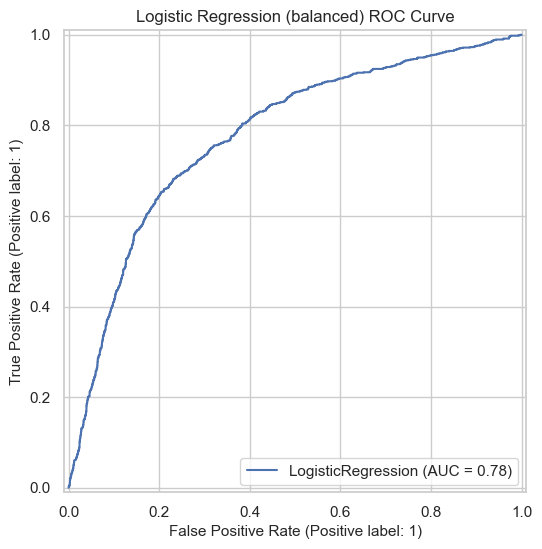

Balanced model: accuracy 0.743, precision 0.488, recall 0.686, ROC AUC 0.777. The class-weighted setting improves recall for the minority class while keeping AUC stable.

In [13]:
# Fit two logistic regression baselines and evaluate
models = {
    "LogisticRegression": LogisticRegression(
        solver="lbfgs", max_iter=4000, tol=1e-3, n_jobs=-1, random_state=RANDOM_STATE
    ),
    "LogisticRegression (balanced)": LogisticRegression(
        solver="lbfgs", max_iter=4000, tol=1e-3, n_jobs=-1, class_weight="balanced", random_state=RANDOM_STATE
    ),
}

metrics_rows = []
for name, clf in models.items():
    clf.fit(X_train_processed, y_train)
    y_pred = clf.predict(X_test_processed)
    y_prob = clf.predict_proba(X_test_processed)[:, 1]
    metrics_rows.append({
        "model": name,
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall":    recall_score(y_test, y_pred, zero_division=0),
        "f1":        f1_score(y_test, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_test, y_prob),
    })

metrics_df = pd.DataFrame(metrics_rows).set_index("model")
display(metrics_df)

balanced_model = models["LogisticRegression (balanced)"]
RocCurveDisplay.from_estimator(balanced_model, X_test_processed, y_test)
plt.title("Logistic Regression (balanced) ROC Curve")
plt.show()

standard_metrics = metrics_df.loc["LogisticRegression"]
balanced_metrics = metrics_df.loc["LogisticRegression (balanced)"]

display(Markdown(
    f"Balanced model: accuracy {balanced_metrics['accuracy']:.3f}, "
    f"precision {balanced_metrics['precision']:.3f}, "
    f"recall {balanced_metrics['recall']:.3f}, "
    f"ROC AUC {balanced_metrics['roc_auc']:.3f}. "
    "The class-weighted setting improves recall for the minority class while keeping AUC stable."
))

## Section 13. Summary and what improved
We summarize imputation, outlier illustration, feature dimensionality, and baseline model results from this run. Counts come from the fitted pipeline to avoid drift.

In [14]:
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

if isinstance(preprocessor, ColumnTransformer):
    column_mapper = preprocessor
elif isinstance(preprocessor, Pipeline) and "columns" in preprocessor.named_steps:
    column_mapper = preprocessor.named_steps["columns"]
else:
    raise ValueError("Expected 'preprocessor' to be a ColumnTransformer or a Pipeline with a 'columns' step.")

# Feature counts
raw_inputs_branch_total = 0
raw_inputs_unique_set = set()
for _, trans, cols in column_mapper.transformers:
    if trans == "drop" or cols == "drop":
        continue
    if isinstance(cols, (list, tuple, np.ndarray)):
        raw_inputs_branch_total += len(cols)
        raw_inputs_unique_set.update(cols)
    else:
        raw_inputs_branch_total += 1
        raw_inputs_unique_set.add(cols)

feature_count_before_encoding_unique = len(raw_inputs_unique_set)
feature_count_before_encoding = raw_inputs_branch_total 

try:
    feature_names = column_mapper.get_feature_names_out()
    feature_count_after = len(feature_names)
except Exception:
    Xt_one = column_mapper.transform(X_train.iloc[[0]])
    feature_count_after = Xt_one.shape[1]
    feature_names = None

# Outlier illustration total (EDA copy), safe fallback if the table is absent
if "total_outliers_capped" not in globals():
    try:
        total_outliers_capped = int(
            outlier_summary_df[["capped_below_demo", "capped_above_demo"]].sum().sum()
        )
    except Exception:
        total_outliers_capped = 0

# Retrieve metrics from Section 12 or recompute from fitted models
def _ensure_log_reg_metrics():
    if "metrics_df" in globals():
        std_ok = "LogisticRegression" in metrics_df.index
        bal_ok = "LogisticRegression (balanced)" in metrics_df.index
        if std_ok and bal_ok:
            return metrics_df.loc["LogisticRegression"], metrics_df.loc["LogisticRegression (balanced)"]

    std_model = None
    bal_model = None
    if "models" in globals():
        std_model = models.get("LogisticRegression")
        bal_model = models.get("LogisticRegression (balanced)")

    rows = {}
    if std_model is not None:
        y_pred = std_model.predict(X_test_processed)
        y_prob = std_model.predict_proba(X_test_processed)[:, 1]
        rows["LogisticRegression"] = {
            "accuracy":  accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall":    recall_score(y_test, y_pred, zero_division=0),
            "f1":        f1_score(y_test, y_pred, zero_division=0),
            "roc_auc":   roc_auc_score(y_test, y_prob),
        }
    if bal_model is not None:
        y_pred = bal_model.predict(X_test_processed)
        y_prob = bal_model.predict_proba(X_test_processed)[:, 1]
        rows["LogisticRegression (balanced)"] = {
            "accuracy":  accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall":    recall_score(y_test, y_pred, zero_division=0),
            "f1":        f1_score(y_test, y_pred, zero_division=0),
            "roc_auc":   roc_auc_score(y_test, y_prob),
        }

    if rows:
        mdf = pd.DataFrame(rows).T
        class _Row(dict):
            __getattr__ = dict.get
        std_row = _Row(mdf.loc["LogisticRegression"].to_dict()) if "LogisticRegression" in mdf.index else None
        bal_row = _Row(mdf.loc["LogisticRegression (balanced)"].to_dict()) if "LogisticRegression (balanced)" in mdf.index else None
        if std_row is not None and bal_row is not None:
            return std_row, bal_row

    raise RuntimeError("Could not locate logistic regression metrics from Section 12.")

standard_metrics, balanced_metrics = _ensure_log_reg_metrics()

if "missing_before_total" not in globals():
    missing_before_total = int(df.isna().sum().sum())
if "missing_after_total" not in globals():
    try:
        modeled_cols = list(set(numeric_features) | set(categorical_features))
    except Exception:
        modeled_cols = df.columns.tolist()
    missing_after_total = int(df[modeled_cols].isna().sum().sum())

processing_md = f"""
### Data processing

**Missing values**: {missing_before_total} before imputation, {missing_after_total} after  
**Outliers (EDA illustration)**: {total_outliers_capped} values shown as capped; robust capping is applied in the train-only pipeline  
**Feature dimensionality**: {feature_count_before_encoding_unique} unique raw inputs ({feature_count_before_encoding} across branches) → {feature_count_after} model features
"""

display(Markdown(processing_md))

metrics_table = pd.DataFrame(
    {
        "accuracy":  [standard_metrics["accuracy"],  balanced_metrics["accuracy"]],
        "precision": [standard_metrics["precision"], balanced_metrics["precision"]],
        "recall":    [standard_metrics["recall"],    balanced_metrics["recall"]],
        "f1":        [standard_metrics["f1"],        balanced_metrics["f1"]],
        "roc_auc":   [standard_metrics["roc_auc"],   balanced_metrics["roc_auc"]],
    },
    index=["LogisticRegression", "LogisticRegression (balanced)"],
)
display(metrics_table.round(3))

if "hgb" in globals():
    y_prob_hgb = hgb.predict_proba(X_test_processed)[:, 1]
    y_pred_hgb = (y_prob_hgb >= 0.5).astype(int)
    hgb_row = pd.DataFrame(
        {
            "accuracy":  [accuracy_score(y_test, y_pred_hgb)],
            "precision": [precision_score(y_test, y_pred_hgb, zero_division=0)],
            "recall":    [recall_score(y_test, y_pred_hgb, zero_division=0)],
            "f1":        [f1_score(y_test, y_pred_hgb, zero_division=0)],
            "roc_auc":   [roc_auc_score(y_test, y_prob_hgb)],
        },
        index=["HistGradientBoosting"],
    )
    display(hgb_row.round(3))


### Data processing

**Missing values**: 20733 before imputation, 0 after  
**Outliers (EDA illustration)**: 984 values shown as capped; robust capping is applied in the train-only pipeline  
**Feature dimensionality**: 15 unique raw inputs (16 across branches) → 133 model features


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.777,0.585,0.363,0.448,0.775
LogisticRegression (balanced),0.743,0.488,0.686,0.571,0.777
